# **CO₂ Contact Angle Predition Challenge**


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from numpy.linalg import pinv
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
# Mount drive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in dataset
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Contact_Angle Project/Train.csv")
train = train.sort_values(by=['mineral','contact_type', 'theta0']).reset_index(drop=True)

test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Contact_Angle Project/Test.csv")

train.head()

,pressure,temperature,salinity,mineral,contact_type,theta0,contact_angle
0,32.868251,309.009477,3.117627,calcite,adv,0,47.496677
1,12.635066,341.108698,0.247334,calcite,adv,0,56.622521
2,28.776101,324.380597,3.643516,calcite,adv,0,42.643842
3,38.418634,300.006464,1.058658,calcite,adv,0,35.274289
4,27.408971,320.644919,5.662101,calcite,adv,0,46.468174


In [ ]:
# understanding if there are null values
train.isnull().sum()

,0
pressure,0
temperature,0
salinity,0
mineral,0
contact_type,0
theta0,0
contact_angle,0


In [ ]:
# checking for null values
test.isna().sum()

,0
pressure,0
temperature,0
salinity,0
mineral,0
contact_type,0
theta0,0


In [ ]:
# train data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pressure       5000 non-null   float64
 1   temperature    5000 non-null   float64
 2   salinity       5000 non-null   float64
 3   mineral        5000 non-null   object 
 4   contact_type   5000 non-null   object 
 5   theta0         5000 non-null   int64  
 6   contact_angle  5000 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 273.6+ KB


In [ ]:
# summary of train data
train.describe()

,pressure,temperature,salinity,theta0,contact_angle
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,17.482869,325.809451,4.004435,1.984400,44.792719
std,10.378542,15.170093,3.529815,1.414128,20.661615
min,0.001229,296.071565,0.000391,0.000000,0.000000
25%,8.778966,314.380324,0.632398,1.000000,30.064237
50%,17.183518,324.450201,3.276164,2.000000,43.547714
75%,25.565436,335.193502,6.580788,3.000000,57.075522
max,39.986961,372.826703,12.870852,4.000000,123.125247


In [ ]:
def plot_overall_kde(df, variables=None, log_transform=False):
    """
    Plots KDE (Kernel Density Estimate) for selected variables in the entire dataset
    (no grouping by mineral type).

    Parameters
    ----------
    df : pd.DataFrame
        Dataset containing numeric variables.
    variables : list of str, optional
        List of numeric variables to plot. If None, uses all numeric columns.
    log_transform : bool, default=False
        If True, applies strict log-transform (log(x + 1e-6)) before plotting.
    """

    if variables is None:
        variables = df.select_dtypes(include="number").columns.tolist()

    fig, axes = plt.subplots(1, len(variables), figsize=(16, 4))

    # Handle the case of single variable
    if len(variables) == 1:
        axes = [axes]

    for j, var in enumerate(variables):
        ax = axes[j]
        values = df[var].dropna()

        if log_transform:values = np.log1p(values.clip(lower=0))

        sns.kdeplot(values, ax=ax, fill=True, color='steelblue', alpha=0.6, linewidth=2)
        ax.set_title(f"{var}" + (" (log)" if log_transform else ""), fontsize=11)
        ax.set_xlabel(var)
        ax.set_ylabel("Density")
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


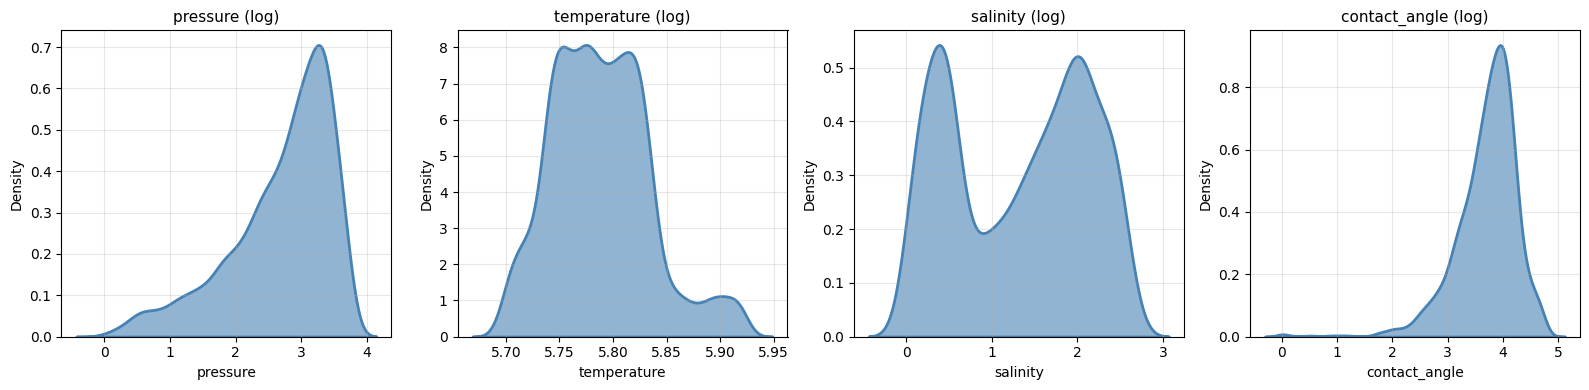

In [ ]:
plot_overall_kde(
    train,
    variables=["pressure", "temperature", "salinity", "contact_angle"],
    log_transform=True
)

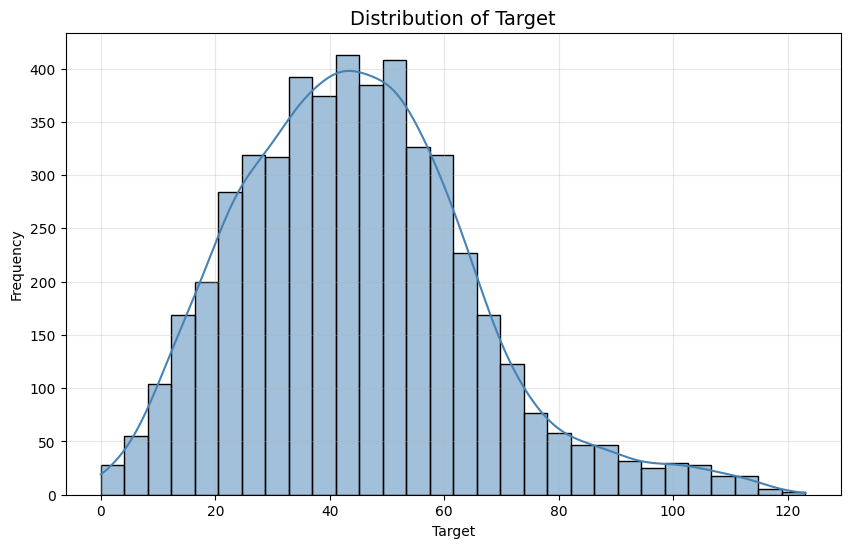

In [ ]:
# Visualize the `Target` distribution
plt.figure(figsize=(10, 6))
sns.histplot(train["contact_angle"], kde=True, color='steelblue', bins=30)
plt.title("Distribution of Target", fontsize=14)
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()



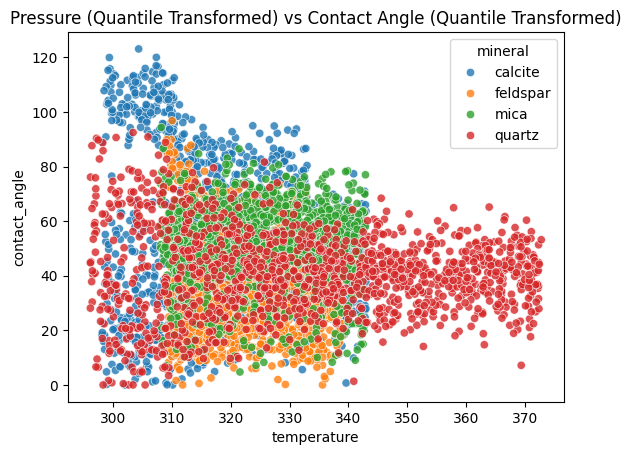

In [ ]:
sns.scatterplot(
    data=train,
    x='temperature',
    y='contact_angle',
    hue='mineral',
    alpha=0.8
)

plt.title('Pressure (Quantile Transformed) vs Contact Angle (Quantile Transformed)')
plt.show()


In [ ]:
train.columns

Index(['pressure', 'temperature', 'salinity', 'mineral', 'contact_type',
       'theta0', 'contact_angle'],
      dtype='object')

### **Model Building**

In [ ]:
# --- Feature & Target Setup ---
target_col = "contact_angle"
feature_cols = ["pressure", "temperature", "salinity", "mineral", "contact_type", "theta0"]

cat_features = ["mineral", "contact_type"]
num_features_to_transform = ["pressure", "temperature", "salinity"]
num_features_pass = ["theta0"]

X = train[feature_cols]
y = train["contact_angle"]

# --- Split data ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Preprocessing ---
cat_transformer = OneHotEncoder(handle_unknown="ignore")
standard_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_features),
        ("num", standard_scaler, num_features_to_transform)
    ],
    remainder="passthrough"  # keeps theta0 as is
)

# --- Model ---
gbr_model = GradientBoostingRegressor(
    n_estimators= 790,
    learning_rate=0.008,
    max_depth= 6,
    subsample=0.85,
    random_state=42
)

# --- Pipeline ---
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", gbr_model)
])

# --- Fit model ---
pipe.fit(X_train, y_train)

# --- Predict in quantile space ---
y_pred = pipe.predict(X_val)

# --- Evaluate model ---
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE (°): {mae:.4f}")
print(f"R²(°): {r2:.4f}")


MSE: 57.3236
MAE (°): 6.0053
R²(°): 0.8660


In [ ]:
# mcalculate mape
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
print(f"Validation MAPE: {mape:.2f}%")

Validation MAPE: 26.97%


In [ ]:
def metrics(y_exp, y_pred):
    y_exp = np.array(y_exp, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    N = len(y_exp)

    # AARE (%)
    AARE = (np.sum(np.abs((y_pred - y_exp) / y_exp)) / N) * 100

    # RMSE
    RMSE = np.sqrt(np.sum((y_pred - y_exp) ** 2) / N)

    # Correlation coefficient (R)
    numerator = np.sum((y_exp - np.mean(y_exp)) * (y_pred - np.mean(y_pred)))
    denominator = np.sqrt(np.sum((y_exp - np.mean(y_exp)) ** 2) * np.sum((y_pred - np.mean(y_pred)) ** 2))
    R = numerator / denominator

    return AARE, RMSE, R

AARE, RMSE, R = metrics(y_val, y_pred)
print(f"AARE (%) = {AARE:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"R = {R:.4f}")


AARE (%) = 26.9661
RMSE = 7.5712
R = 0.9309


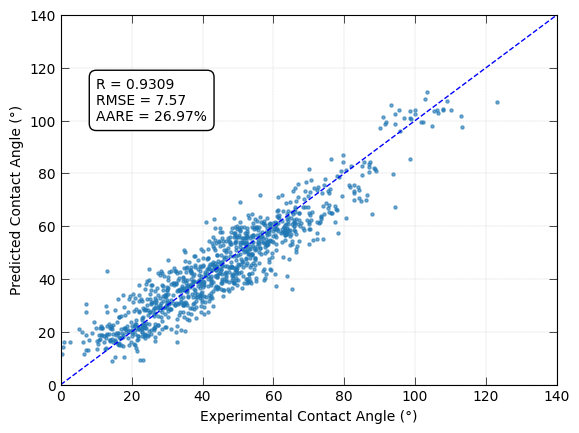

In [ ]:
plt.scatter(y_val, y_pred, alpha=0.6, s=5)
plt.plot([0, 140], [0, 140], 'b--', lw=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.tick_params(axis='both', which='both', direction='in',
                length=6, width=0.5, top=True, right=True)
plt.xlabel('Experimental Contact Angle (°)')
plt.ylabel('Predicted Contact Angle (°)')
# plt.title('Predicted vs Experimental Contact Angle')
plt.text(10, 100, f'R = {R:.4f}\nRMSE = {RMSE:.2f}\nAARE = {AARE:.2f}%', fontsize=10,
          bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=0.5))
plt.xlim(0, 140)
plt.ylim(0, 140)
plt.show()

In [ ]:
import pickle
# Save Model
model_file = f"contact_angle_pred_model.bin"

with open(model_file, "wb") as f_out:
    pickle.dump(pipe, f_out)

# Load Model 
with open(model_file, "rb") as f_in:
    model = pickle.load(f_in)

# Predict on test data
test_pred = pipe.predict(test)
Prediction= pd.DataFrame({"id":test.index,
                           "contact_angle":test_pred})

print(f"Prediction\n {Prediction}")